# Machine Learning

## Prophet

### Jorge de Toro, Juan A. Ortíz

### Predicción series temporales by month

# Prophet

Prophet es una biblioteca de código abierto desarrollada por Facebook y que fue diseñada para el pronóstico automático de datos de series de tiempo univariadas. Uno de sus puntos fuertes es que es fácil de usar y está diseñada para encontrar de forma automática un buen conjunto de hiperparámetros del modelo para poder realizar pronósticos hábiles para datos con tendencias y estructura estacional


In [1]:
#pip install pystan == 2.19.1.1
#pip install fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import relativedelta
from monthdelta import monthdelta
import pickle
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics


print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


### Carga de datos

Cargaremos los datos de venta y las fechas de las promociones, tanto diaria como mensual.


In [2]:
df_MonthSales =pd.DataFrame()
df_DailySales =pd.DataFrame()
df_Promo =pd.DataFrame()

df_MonthSales= pd.read_csv('C:/Users/txico/El Corte Inglés, S.A/Otb y el master - Documentos/VentaMes2017-2019.csv'
                 ,';',index_col='Fecha Venta',parse_dates=True)


df_DailySales= pd.read_csv('C:/Users/txico/El Corte Inglés, S.A/Otb y el master - Documentos/VentaDia 2017-2019.csv'
                 ,';',index_col='Fecha Venta',parse_dates=True)

df_Promo= pd.read_csv('C:/Users/txico/El Corte Inglés, S.A/Otb y el master - Documentos/PromoDia 2017-2019.csv'
                 ,';',parse_dates=True)


Modificamos el Tipo de dato de df_Promo y ordenamos por fechas de venta.

In [3]:
df_Promo["PROMO"] = df_Promo.PROMO.astype('string')
df_Promo['Fecha'] = pd.to_datetime(df_Promo['Fecha'],format="%d/%m/%Y")
df_Promo = df_Promo.sort_values('Fecha')
df_DailySales = df_DailySales.sort_values('Fecha Venta')
df_MonthSales = df_MonthSales.sort_values('Fecha Venta')

Generamos los dataframe en formato Prophet

In [4]:
df_MonthSales = df_MonthSales.reset_index(level=0).copy()
df_MonthSales.rename(columns = {'Fecha Venta':'ds', 'Unidades Vendidas':'y'},inplace=True)

df_DailySales = df_DailySales.reset_index(level=0).copy()
df_DailySales.rename(columns = {'Fecha Venta':'ds', 'Unidades Vendidas':'y'},inplace=True)


df_Promo.rename(columns = {'Fecha':'ds', 'PROMO':'holiday'},inplace=True)

A partir de este punto trabajaremos con las ventas diarias hasta que lleguemos al apartado del modelo mensual.

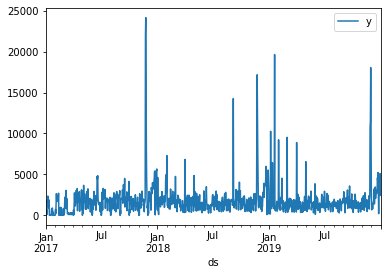

In [5]:
df_DailySales['ds']=pd.to_datetime(df_DailySales.ds,format="%d/%m/%Y")
df_DailySales.plot(x='ds',y='y')

In [6]:

df_DailySales.head()


,ds,y
0,2017-01-01,243.000
1,2017-01-02,2.299
2,2017-01-03,2.414
3,2017-01-04,622.000
4,2017-01-05,126.000


Seleccionamos los conjuntos de test y entrenamiento, en este caso el conjunto de test estará compuesto por la venta de los dias del mes de diciembre de 2019:

In [7]:
#fecha de entrenamiento del primer caso de test
test_date_from = "12/01/2019"
test_date_from


'12/01/2019'

In [8]:
#conjutos de test y entrenamiento
df_test = df_DailySales.loc[df_DailySales.ds >= test_date_from]
df_train = df_DailySales.loc[df_DailySales.ds < test_date_from]

In [9]:
print (df_train.head(),"\n")
print (df_train.info(),"\n")
print (df_train.head(),"\n")
print (df_train.info(),"\n")

          ds        y
0 2017-01-01  243.000
1 2017-01-02    2.299
2 2017-01-03    2.414
3 2017-01-04  622.000
4 2017-01-05  126.000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1063
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1064 non-null   datetime64[ns]
 1   y       1064 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.9 KB
None 

          ds        y
0 2017-01-01  243.000
1 2017-01-02    2.299
2 2017-01-03    2.414
3 2017-01-04  622.000
4 2017-01-05  126.000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 1063
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1064 non-null   datetime64[ns]
 1   y       1064 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.9 KB
None 



### Aplicación del modelo Ventas diarias

Aplicamos Prophet a la serie temporal de ventas sin añadir las promociones. Seleccionamos los parametros de estacionalidad.

In [10]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
m.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Creamos el periodo que queremos predecir, los 31 dias de diciembre 2019

In [11]:
future=m.make_future_dataframe(periods=31)

In [12]:
future.tail()

,ds
1090,2019-12-27
1091,2019-12-28
1092,2019-12-29
1093,2019-12-30
1094,2019-12-31


#### Realizamos la predicción

In [13]:
forecast=m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2019-12-27,3234.573208,986.122536,5503.344634
1091,2019-12-28,3360.736395,1141.365958,5401.600146
1092,2019-12-29,2607.227800,432.117638,4768.813383
1093,2019-12-30,2828.170586,566.790136,5077.376016
1094,2019-12-31,2843.279783,561.284263,5138.914095


#### Unimos la predicción con el valor real de las ventas diarias para comparar.

In [14]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [15]:

comp_df=make_comparison_dataframe(df_DailySales,forecast)
comp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-12-27,3234.573208,986.122536,5503.344634,4176.0
2019-12-28,3360.736395,1141.365958,5401.600146,4522.0
2019-12-29,2607.227800,432.117638,4768.813383,3401.0
2019-12-30,2828.170586,566.790136,5077.376016,5104.0
2019-12-31,2843.279783,561.284263,5138.914095,2439.0


#### Representamos la predicción y la venta real así como el intervalo yhat_lower-yhat_upper

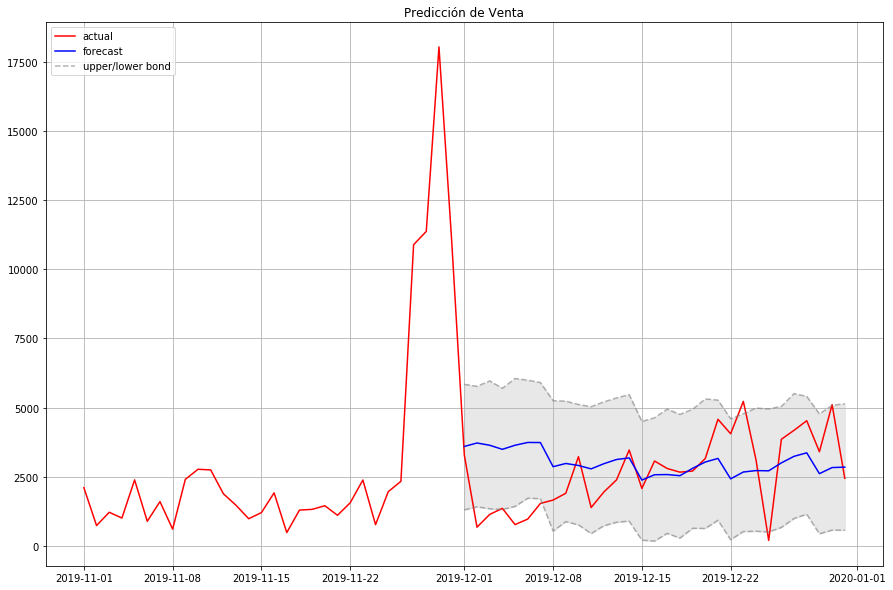

In [16]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    plt.figure(figsize=(15,10))
    plt.plot(cmp_df['y'][-num_values:], 'r', label='actual')
    plt.plot(cmp_df['yhat'][-num_predictions:], 'b', label='forecast')
    plt.plot(cmp_df['yhat_upper'][-num_predictions:], 'gray', alpha=0.6, linestyle='dashed', label='upper/lower bond')
    plt.plot(cmp_df['yhat_lower'][-num_predictions:], 'gray', alpha=0.6, linestyle='dashed')
    plt.legend(loc='upper left')
    plt.fill_between(x=cmp_df.index[-num_predictions:], y1=cmp_df['yhat_upper'][-num_predictions:],
    y2=cmp_df['yhat_lower'][-num_predictions:], alpha=0.5, color='lightgrey')
    plt.title(title)
    plt.grid(True)

show_forecast(comp_df,31,61, 'Predicción de Venta')

plt.show()

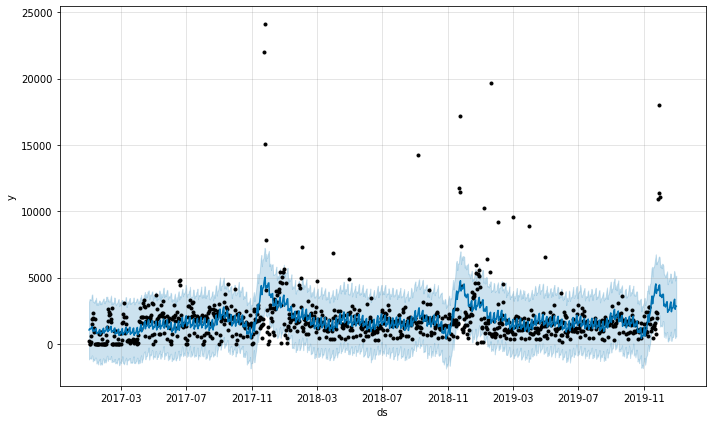

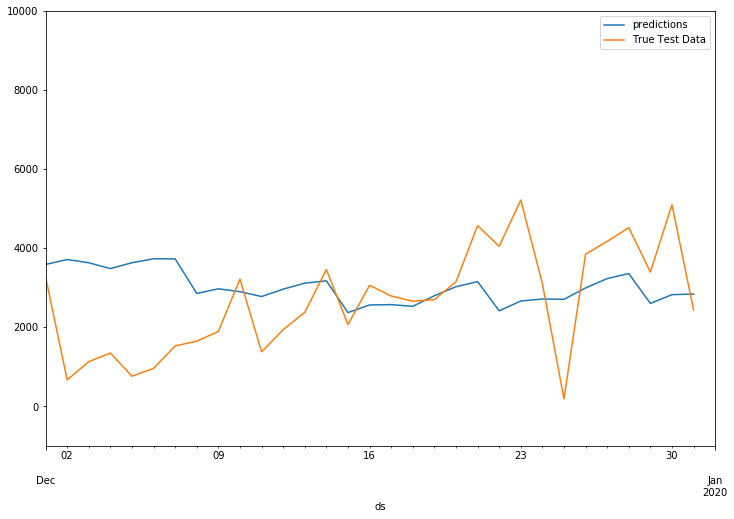

In [17]:
m.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
df_test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-12-01','2020-01-01'),ylim=(-1000,10000))

#### Analizamos los componentes del forecast

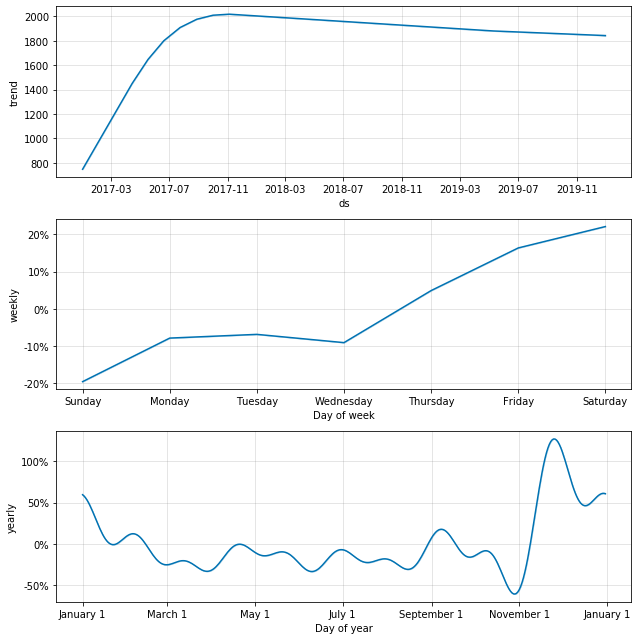

In [18]:
fig2=m.plot_components(forecast)

#### Utilizamos el mismo modelo pero con validación cruzada.

In [19]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
m.fit(df_DailySales)
pr_cv=cross_validation(m,initial='722 days',period='31 days', horizon='31 days')
pr_cv.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-12-24 00:00:00 and 2019-11-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,3201.399593,1103.534804,5374.836614,87.0,2018-12-24
1,2018-12-26,3044.033404,818.954434,5300.087335,4600.0,2018-12-24
2,2018-12-27,3642.243377,1575.306054,5853.296144,5252.0,2018-12-24
3,2018-12-28,3539.388016,1247.775612,5655.534992,5083.0,2018-12-24
4,2018-12-29,3610.091209,1402.841785,5710.504829,5530.0,2018-12-24


In [20]:
pr_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,3201.399593,1103.534804,5374.836614,87.0,2018-12-24
1,2018-12-26,3044.033404,818.954434,5300.087335,4600.0,2018-12-24
2,2018-12-27,3642.243377,1575.306054,5853.296144,5252.0,2018-12-24
3,2018-12-28,3539.388016,1247.775612,5655.534992,5083.0,2018-12-24
4,2018-12-29,3610.091209,1402.841785,5710.504829,5530.0,2018-12-24


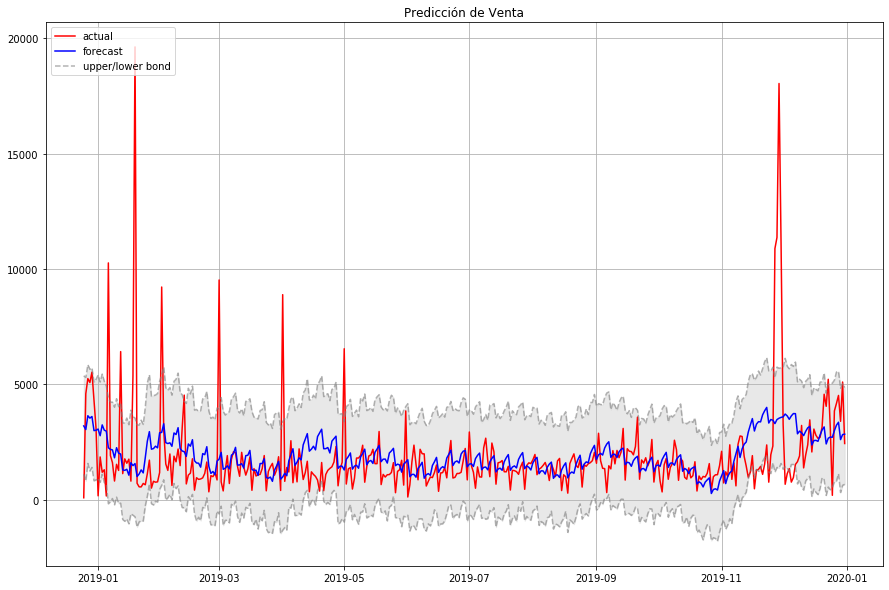

In [21]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,372,372, 'Predicción de Venta')

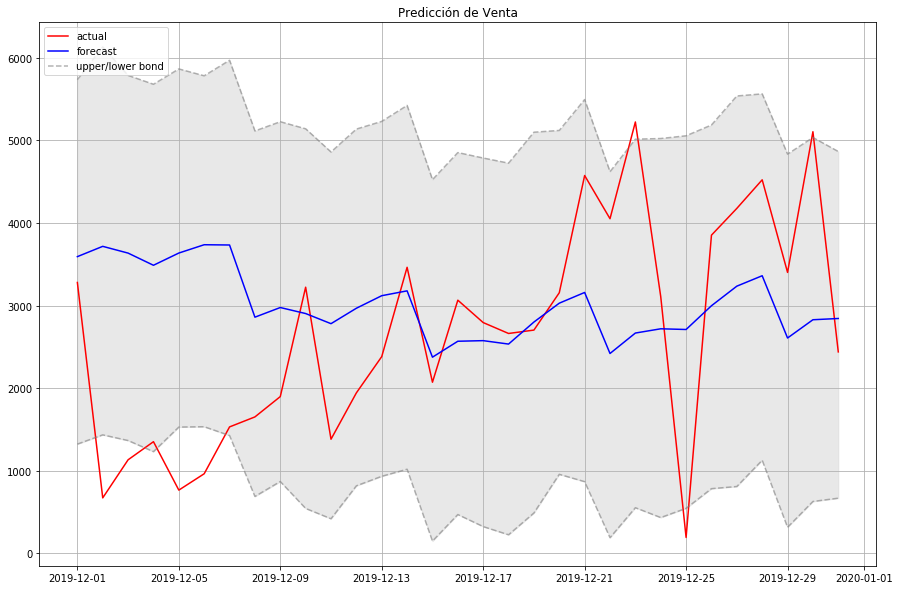

In [22]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,31,31, 'Predicción de Venta')

In [23]:
df_p = performance_metrics(pr_cv)
df_p.tail()


,horizon,mse,rmse,mae,mape,mdape,coverage
23,27 days,1.006794e+07,3173.001877,1287.473272,1.017561,0.478637,0.891892
24,28 days,1.091227e+07,3303.373012,1289.018679,0.576665,0.476261,0.939189
25,29 days,4.428565e+06,2104.415695,1033.344480,0.621737,0.476261,0.943694
26,30 days,9.466223e+06,3076.722759,1390.210002,0.631721,0.445891,0.891892
27,31 days,9.550424e+06,3090.376072,1402.707859,0.678926,0.492929,0.889640


In [24]:
df_p.mean()

horizon     17 days 12:00:00
mse           3585316.282495
rmse             1723.626186
mae                 998.9715
mape                0.887676
mdape               0.413136
coverage            0.920689
dtype: object

#### Aplicamos el modelo aditivo

In [25]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.fit(df_DailySales)
pr_cv=cross_validation(m,initial='722 days',period='31 days', horizon='31 days')
pr_cv.head()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-12-24 00:00:00 and 2019-11-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,3061.259926,749.603544,5208.673247,87.0,2018-12-24
1,2018-12-26,2916.479244,786.348936,5115.251369,4600.0,2018-12-24
2,2018-12-27,3409.949576,1196.041561,5648.179486,5252.0,2018-12-24
3,2018-12-28,3321.815649,1162.473784,5553.816588,5083.0,2018-12-24
4,2018-12-29,3335.177373,1218.805767,5536.465200,5530.0,2018-12-24


In [26]:
pr_cv.cutoff

0     2018-12-24
1     2018-12-24
2     2018-12-24
3     2018-12-24
4     2018-12-24
         ...    
367   2019-11-30
368   2019-11-30
369   2019-11-30
370   2019-11-30
371   2019-11-30
Name: cutoff, Length: 372, dtype: datetime64[ns]

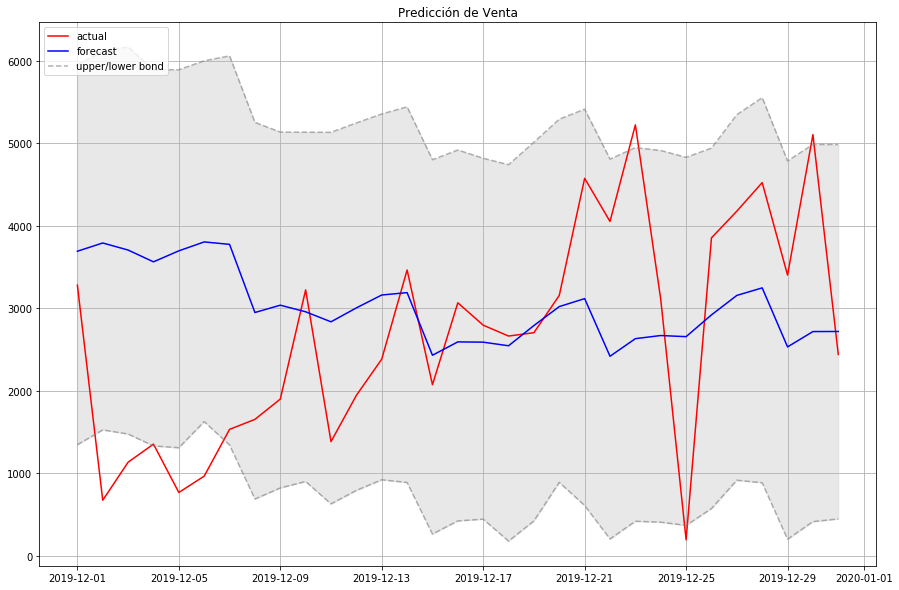

In [27]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,31,31, 'Predicción de Venta')

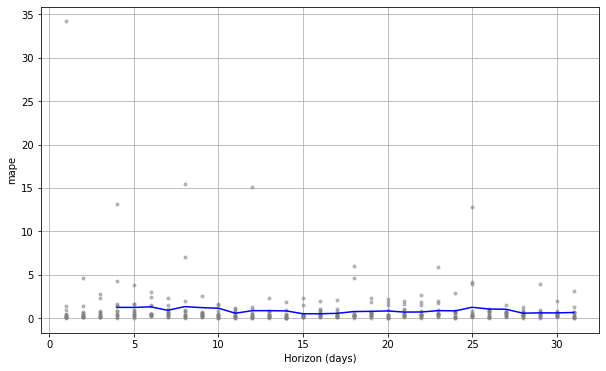

In [28]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(pr_cv, metric='mape')

In [29]:
df_p = performance_metrics(pr_cv)
df_p.head()
df_p.mean()

horizon     17 days 12:00:00
mse           3599928.178109
rmse             1729.878388
mae               983.146693
mape                 0.85141
mdape                0.40147
coverage             0.91176
dtype: object

#### Aplicamos  modelo aditivo pero ajustando parametros de estacionalidad y tendencia

In [30]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=15, changepoint_range=0.85)
m.fit(df_DailySales)
pr_cv=cross_validation(m,initial='722 days',period='31 days', horizon='31 days')
pr_cv.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-12-24 00:00:00 and 2019-11-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,4343.395641,2303.599433,6383.836767,87.0,2018-12-24
1,2018-12-26,3965.620221,2042.576932,5962.198776,4600.0,2018-12-24
2,2018-12-27,4185.295539,2183.092774,6230.941891,5252.0,2018-12-24
3,2018-12-28,3795.442429,1833.325684,5815.729643,5083.0,2018-12-24
4,2018-12-29,3496.960739,1512.591367,5484.520253,5530.0,2018-12-24


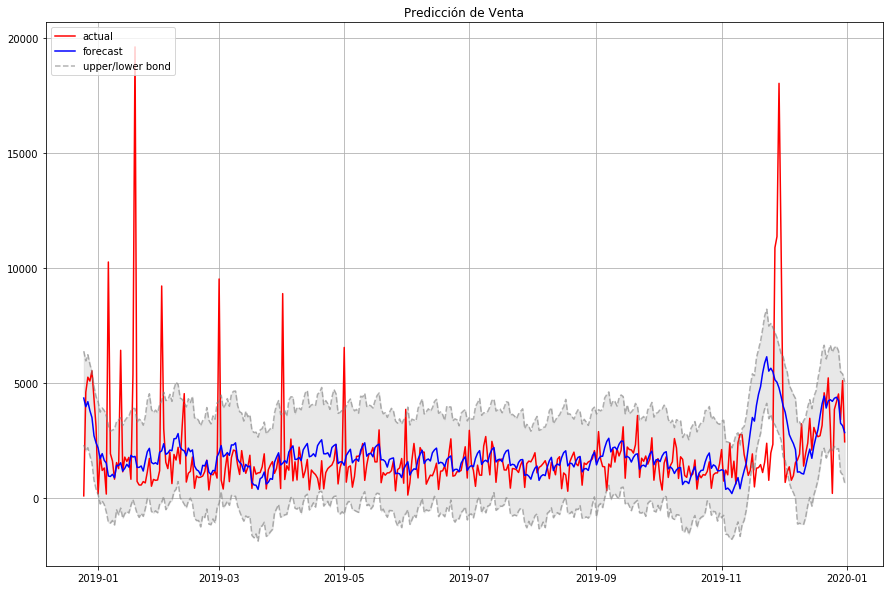

In [31]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,372,372, 'Predicción de Venta')

In [32]:
df_p = performance_metrics(pr_cv)
df_p.mean()

horizon     17 days 12:00:00
mse           3543833.990723
rmse              1741.11962
mae               970.262339
mape                0.844845
mdape               0.376546
coverage            0.916667
dtype: object

#### Aplicamos el modelo anterior incluyendo vacaciones del pais (España)

In [33]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=15, changepoint_range=0.85)
m.add_country_holidays(country_name='ES')
m.fit(df_DailySales)
pr_cv=cross_validation(m,initial='722 days',period='31 days', horizon='31 days')
pr_cv.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-12-24 00:00:00 and 2019-11-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,289.155829,-1702.961818,2358.531069,87.0,2018-12-24
1,2018-12-26,4321.688357,2354.635560,6407.226909,4600.0,2018-12-24
2,2018-12-27,4528.166451,2636.468730,6585.328196,5252.0,2018-12-24
3,2018-12-28,4126.057537,1967.026380,6108.554607,5083.0,2018-12-24
4,2018-12-29,3824.884735,1829.923071,5759.745196,5530.0,2018-12-24


In [34]:
m.train_holiday_names

0                    Año nuevo (Trasladado)
1                        Epifanía del Señor
2                        Día del Trabajador
3                     Asunción de la Virgen
4                      Día de la Hispanidad
5                          Todos los Santos
6           Día de la Constitución Española
7                  La Inmaculada Concepción
8                                   Navidad
9                                 Año nuevo
10          Epifanía del Señor (Trasladado)
11    La Inmaculada Concepción (Trasladado)
dtype: object

In [35]:
df_p = performance_metrics(pr_cv)
df_p.mean()

horizon     17 days 12:00:00
mse           3443984.165994
rmse             1714.003798
mae               942.202246
mape                  0.7464
mdape                0.38118
coverage            0.923665
dtype: object

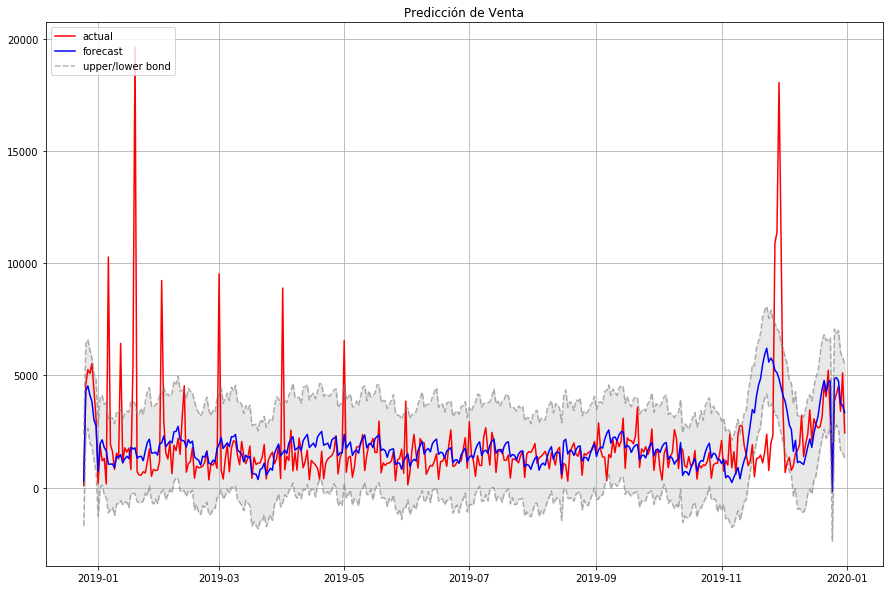

In [36]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,372,372, 'Predicción de Venta')

In [37]:
def get_initial_param(df, iter_number =12,window_size = 31):
    return "{} days".format(len(df)-(iter_number)*window_size-1)

In [38]:
df1=get_initial_param(df_DailySales)

In [39]:
df1

'722 days'

In [40]:
from sklearn.metrics import mean_squared_error, confusion_matrix
from math import sqrt
rmse_lr=sqrt(mean_squared_error(pr_cv[-31:].yhat,pr_cv[-31:].y))

In [41]:
rmse_lr

1150.032861168012

#### Aplicamos el modelo anterior incluyendo eventos significativos

In [42]:
df_Promo['upper_window']=0
df_Promo['lower_window']=0

df_Promo.loc[df_Promo.holiday=='BLACK FRIDAY','upper_window']=2
df_Promo.loc[df_Promo.holiday=='BLACK FRIDAY','lower_window']=-1
df_Promo.loc[df_Promo.holiday=='DIA SIN IVA','lower_window']=-1
df_Promo.loc[df_Promo.holiday=='CYBER MONDAY','lower_window']=-1


In [43]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=15, holidays=df_Promo, changepoint_range=0.85)
m.add_country_holidays(country_name='ES')
m.fit(df_DailySales)
pr_cv=cross_validation(m,initial='722 days',period='31 days', horizon='31 days')
pr_cv.head()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-12-24 00:00:00 and 2019-11-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-25,-112.485485,-1464.852553,1165.652105,87.0,2018-12-24
1,2018-12-26,4194.259432,2847.952934,5561.534444,4600.0,2018-12-24
2,2018-12-27,4248.219971,2934.843252,5626.944910,5252.0,2018-12-24
3,2018-12-28,3911.199415,2615.716703,5152.347996,5083.0,2018-12-24
4,2018-12-29,3888.061742,2579.982446,5168.669478,5530.0,2018-12-24


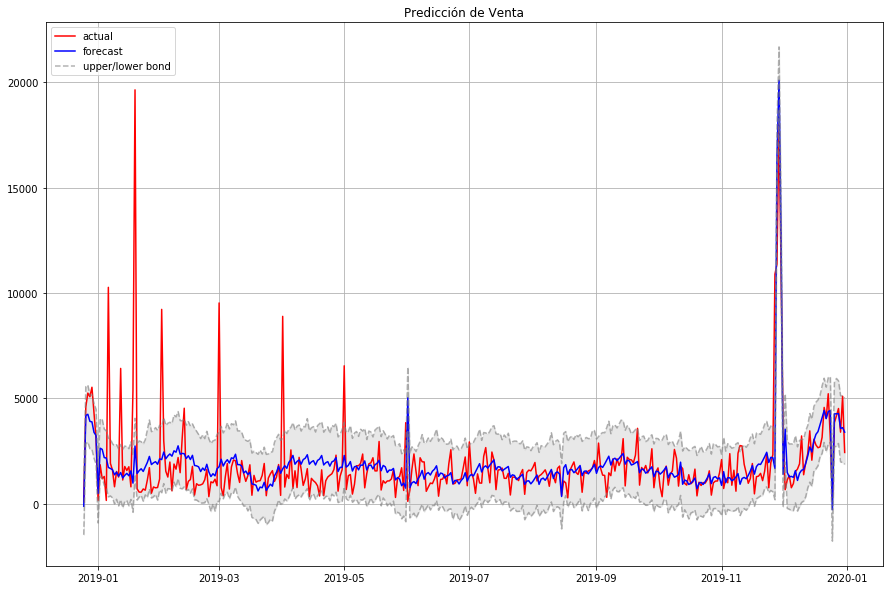

In [44]:
comp_df=make_comparison_dataframe(df_DailySales,pr_cv)
show_forecast(comp_df,372,372, 'Predicción de Venta')

In [45]:
df_p = performance_metrics(pr_cv)
df_p.mean()

horizon     17 days 12:00:00
mse           2645070.192158
rmse             1459.351085
mae               778.068966
mape                  0.7273
mdape               0.304811
coverage            0.929537
dtype: object

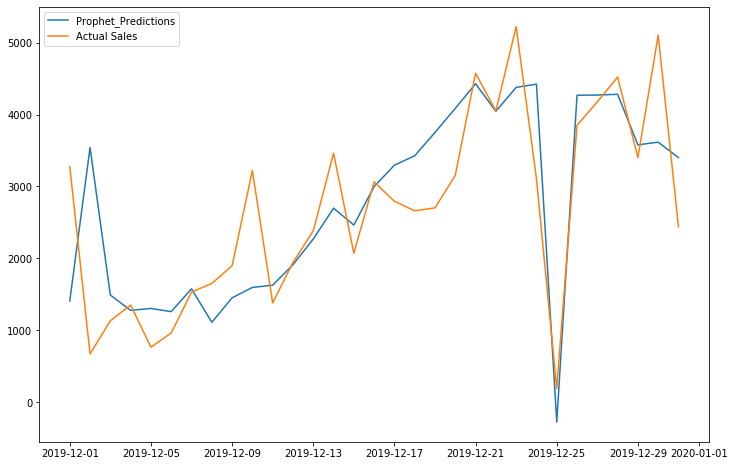

In [46]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
ax=pr_cv[-31:].ds
plt.plot(pr_cv[-31:].ds,pr_cv[-31:].yhat,label='Prophet_Predictions')
plt.plot(pr_cv[-31:].ds,pr_cv[-31:].y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()


In [47]:
from sklearn.metrics import mean_squared_error, confusion_matrix
from math import sqrt
rmse_lr=sqrt(mean_squared_error(pr_cv[-31:].yhat,pr_cv[-31:].y))

In [48]:
rmse_lr

899.7981615439065

### Aplicación del modelo Ventas mensuales


In [49]:
#fecha de entrenamiento del primer caso de test
test_date_from = "03/01/2019"
test_date_from


'03/01/2019'

In [50]:
#conjutos de test y entrenamiento
df_test = df_MonthSales.loc[df_MonthSales.ds >= test_date_from]
df_train = df_MonthSales.loc[df_MonthSales.ds < test_date_from]

In [51]:
df_test.head()

,ds,y
26,2019-03-01,37323
27,2019-04-01,37094
28,2019-05-01,46596
29,2019-06-01,42994
30,2019-07-01,44742


In [52]:
df_train.head()

,ds,y
0,2017-01-01,94158
1,2017-02-01,30152
2,2017-03-01,38901
3,2017-04-01,58229
4,2017-05-01,59880


In [53]:
m = Prophet()
m.fit(df_MonthSales)
future=m.make_future_dataframe(periods=365)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


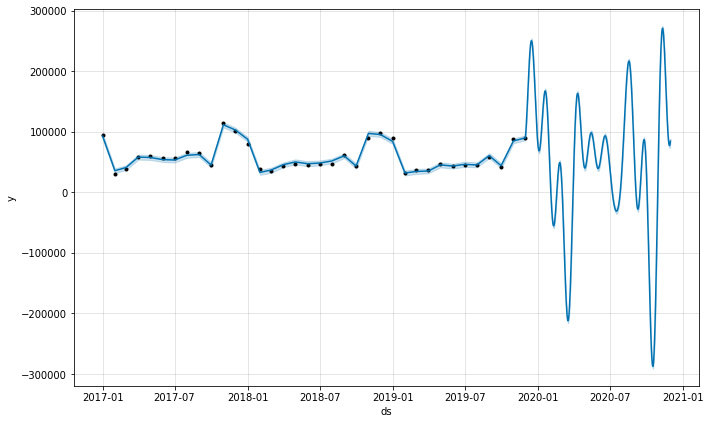

In [54]:
m = Prophet().fit(df_MonthSales)
future = m.make_future_dataframe(periods=365)
fcst = m.predict(future)
fig = m.plot(fcst)

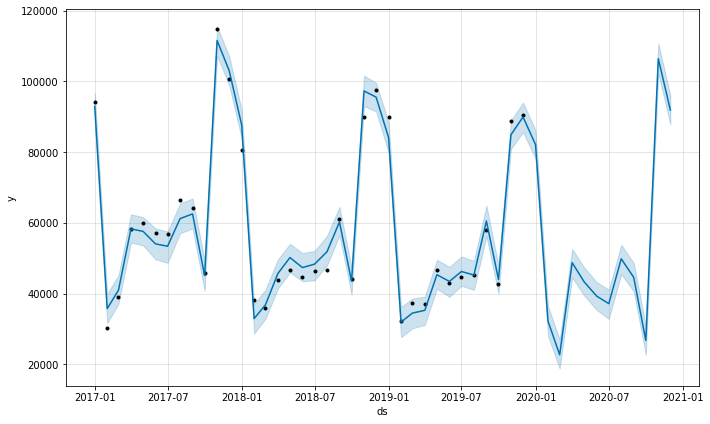

In [55]:
future = m.make_future_dataframe(periods=12, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


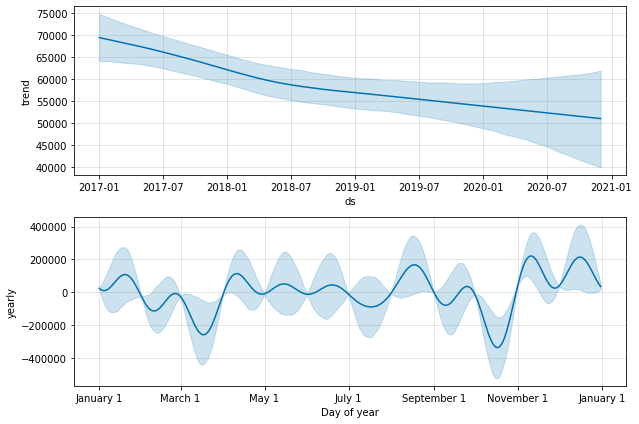

In [56]:
m = Prophet( mcmc_samples=300).fit(df_MonthSales)
fcst = m.predict(future)
fig = m.plot_components(fcst)

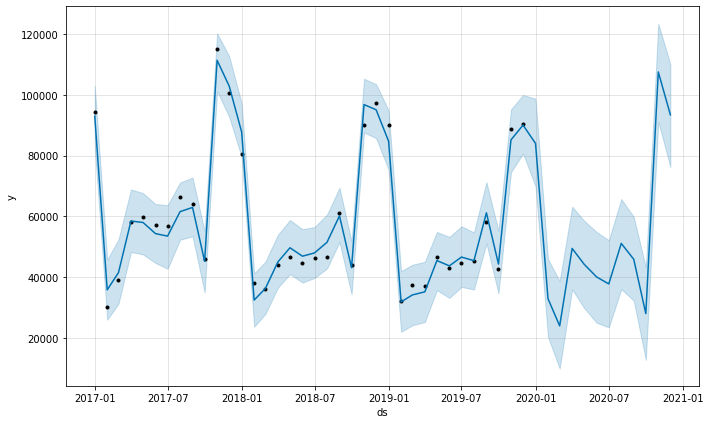

In [57]:
future = m.make_future_dataframe(periods=12, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Aplicamos el modelo aditivo al conjunto test

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


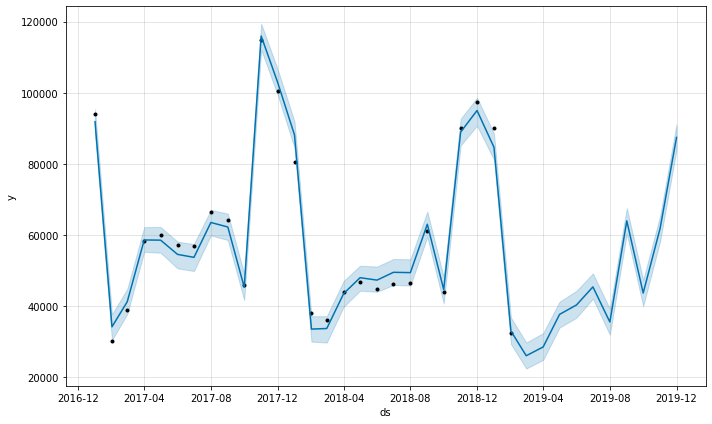

In [58]:
m = Prophet()
m.fit(df_train)
future =m.make_future_dataframe(periods=10, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)


In [59]:
comp_df=make_comparison_dataframe(df_MonthSales,fcst)
comp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-08-01,35494.997678,31910.130585,39175.334463,45341
2019-09-01,63957.020025,60331.547084,67545.407150,58027
2019-10-01,43653.808253,39960.946229,47325.683769,42642
2019-11-01,61870.556941,58266.576410,65401.246662,88793
2019-12-01,87433.878048,84001.552988,91156.739990,90449


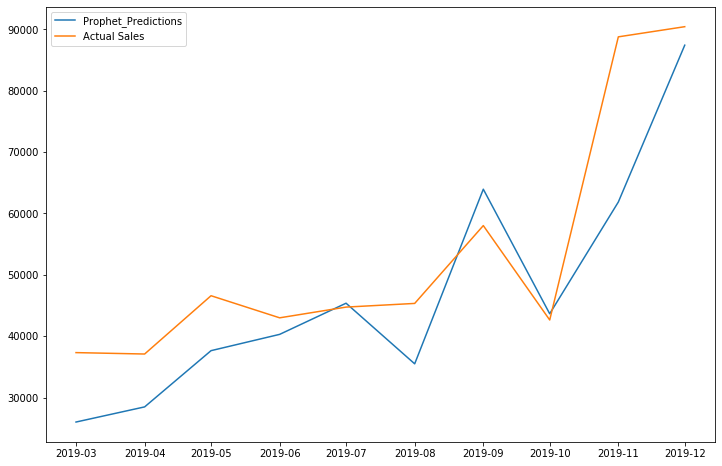

In [60]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
ax=fcst.ds
plt.plot(fcst[-10:].ds,fcst[-10:].yhat,label='Prophet_Predictions')
plt.plot(df_test.ds,df_test.y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [61]:
rmse_lr=sqrt(mean_squared_error(fcst[-10:].yhat,df_test.y))
rmse_lr

10757.409540715491

#### Aplicamos el modelo multiplicativo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


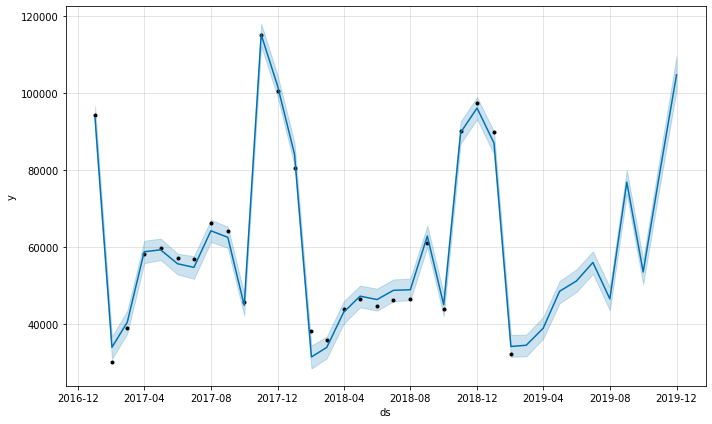

In [62]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train)
future =m.make_future_dataframe(periods=10, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)


In [63]:
comp_df=make_comparison_dataframe(df_MonthSales,fcst)
comp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-08-01,46574.223156,43580.641447,49557.016644,45341
2019-09-01,76839.271788,73749.552411,80009.950952,58027
2019-10-01,53560.624361,50374.454910,56746.016114,42642
2019-11-01,79842.360421,76292.343728,83832.107008,88793
2019-12-01,104697.057372,100608.311400,109455.496998,90449


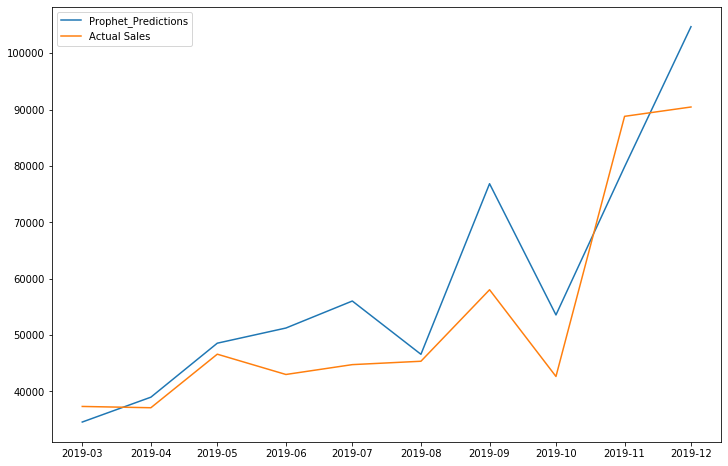

In [64]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
ax=fcst.ds
plt.plot(fcst[-10:].ds,fcst[-10:].yhat,label='Prophet_Predictions')
plt.plot(df_test.ds,df_test.y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [65]:
rmse_lr=sqrt(mean_squared_error(fcst[-10:].yhat,df_test.y))
rmse_lr

9838.550107183219

#### Aplicamos el modelo multiplicativo ajustando parametros

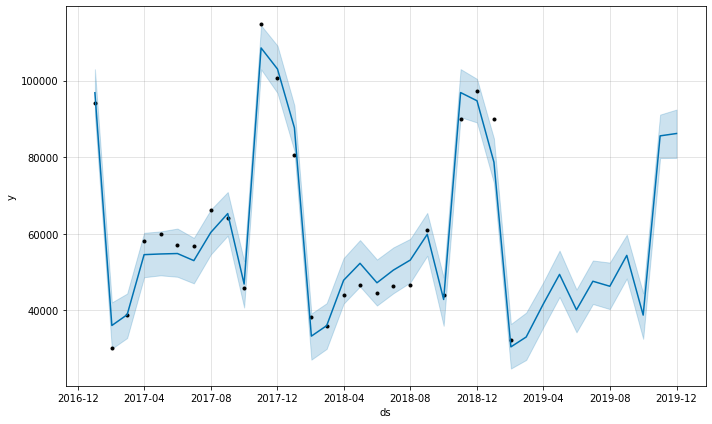

In [109]:
m = Prophet(seasonality_mode='multiplicative',weekly_seasonality=False,daily_seasonality=False, yearly_seasonality=7, n_changepoints=19)
m.fit(df_train)
future =m.make_future_dataframe(periods=10, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)


In [110]:
comp_df=make_comparison_dataframe(df_MonthSales,fcst)
comp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-08-01,46286.660300,40321.701525,52471.017126,45341
2019-09-01,54352.148281,48307.454220,59727.686612,58027
2019-10-01,38749.697307,32550.233890,44480.058979,42642
2019-11-01,85579.580929,79774.912203,91137.323431,88793
2019-12-01,86195.720408,79814.007313,92449.644489,90449


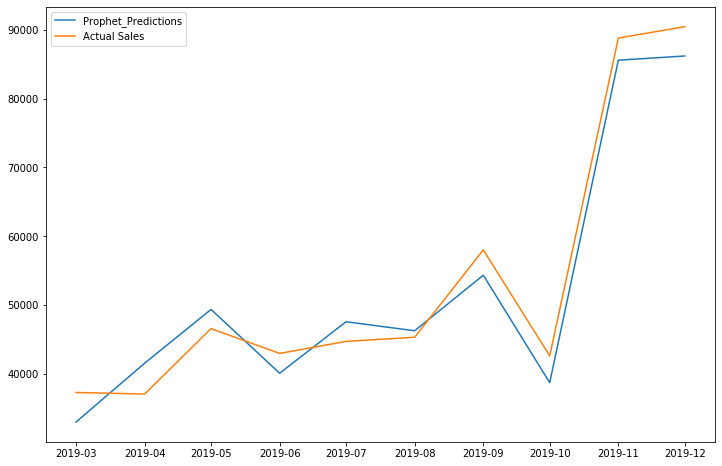

In [111]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
ax=fcst.ds
plt.plot(fcst[-10:].ds,fcst[-10:].yhat,label='Prophet_Predictions')
plt.plot(df_test.ds,df_test.y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [112]:
rmse_lr=sqrt(mean_squared_error(fcst[-10:].yhat,df_test.y))
rmse_lr

3473.484953934847

#### Aplicamos el modelo aditivo ajustando parametros

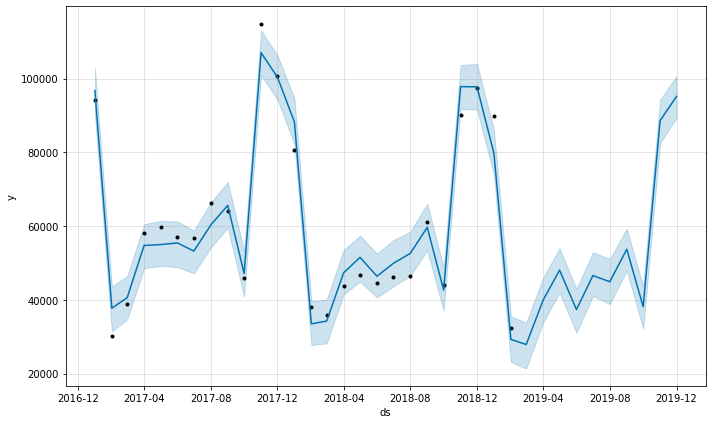

In [126]:
m = Prophet(weekly_seasonality=False,daily_seasonality=False, yearly_seasonality=7, n_changepoints=19)
m.fit(df_train)
future =m.make_future_dataframe(periods=10, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)


In [127]:
comp_df=make_comparison_dataframe(df_MonthSales,fcst)
comp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-08-01,44913.714650,38837.277365,51142.585867,45341
2019-09-01,53728.405289,47889.032380,59281.325558,58027
2019-10-01,38150.546747,32182.944666,43730.958846,42642
2019-11-01,88623.324507,82520.224642,94283.055881,88793
2019-12-01,95153.580921,89254.743775,100722.751072,90449


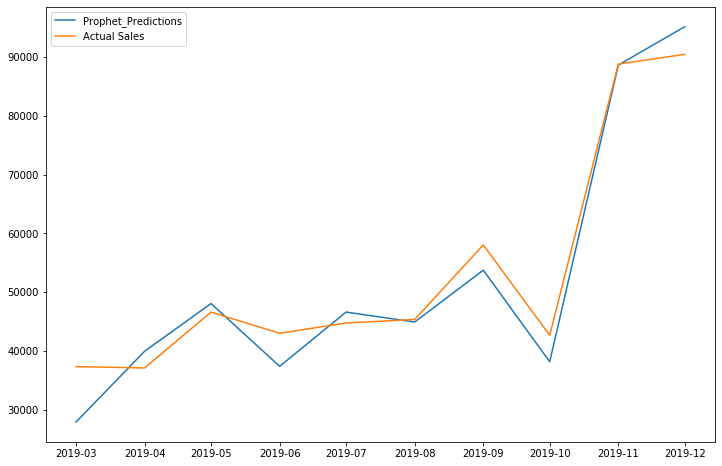

In [128]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
ax=fcst.ds
plt.plot(fcst[-10:].ds,fcst[-10:].yhat,label='Prophet_Predictions')
plt.plot(df_test.ds,df_test.y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [129]:
rmse_lr=sqrt(mean_squared_error(fcst[-10:].yhat,df_test.y))
rmse_lr

4418.261824507179